# Attention is All You Need
源自：
> http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder

> https://zhuanlan.zhihu.com/p/48731949

> https://zhuanlan.zhihu.com/p/82312421

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, time, copy
from torch.autograd import  Variable
import matplotlib.pyplot as plt
import seaborn
import os
import sys
seaborn.set_context( context='talk' )
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 判断是否有GPU可用
#device = 'cpu'
print( 'device=', device )
print(torch.__version__)

device= cuda
2.0.1+cu118


The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed- forward network.<br>
<img src="https://pic1.zhimg.com/v2-1d9129c9c0d5367591bd093f79155e40_r.jpg" height="800" width="600" />

<strong>编码器-解码器(EncoderDecoder)</strong><br>

In [2]:
class EncoderDecoder( nn.Module ):
    '''
    A standard Encoder-Decoder architecture. Base for this and many other models.
    '''
    def __init__( self, encoder, decoder, src_embed, tgt_embed, generator ):
        """初始化函数中有5个参数，分别是编码器对象，解码器对象，源数据嵌入函数，目标数据嵌入函数，以及输出部分的类别生成器对象"""
        super( EncoderDecoder, self ).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward( self, src, tgt, src_mask, tgt_mask ):
        '''Take in and process masked src and target sequences.'''
        """“在forward函数中，有四个参数，source代表源数据，target代表目标数据source_mask和target_mask代表对应的掩码张量"""
        # 在函数中，将source，source_mask传入编码函数，得到结果后
        # 与source_mask，target，和target_mask一同传给解码函数
        return self.decode( self.encode( src, src_mask ), src_mask, tgt, tgt_mask )

    def encode( self, src, src_mask ):
        """编码函数，以source和source_mask为参数"""
        # 使用src_embed对source做处理，然后和source_mask一起传给self.encoder
        return self.encoder( self.src_embed( src ), src_mask )
    
    def decode( self, memory, src_mask, tgt, tgt_mask ):
        """"解码函数，以memory即编码器的输出，source_mask，target，target_mask为参数"""
        # 使用tgt_embed对target做处理，然后和source_mask，target_mask，memory一起传给self.decoder
        return self.decoder( self.tgt_embed( tgt ), memory, src_mask, tgt_mask )


<strong>输出层(Generator)</strong><br>
<ul>输出层包含：
<li> 线性层 ：通过对上一步的线性变化得到指定维度的输出,也就是转换维度的作用</li>
<li> softmax层：使最后一维的向量中的数字缩放到0-1的概率值域内并满足他们的和为1</li>
</ul>

In [3]:
#将线性层和softmax计算层一起实现，因为二者的共同目标是生成最后的结构
#因此把类的名字叫做Generator，生成器类
class Generator( nn.Module ):
    '''Define standard linear + softmax generation step.'''
    def __init__( self, d_model, vocab ):
        """初始化函数的输入参数有两个，d_model代表词嵌入维度，vocab_size代表词表大小."""
        super( Generator, self ).__init__()
        self.proj = nn.Linear( d_model, vocab )

    def forward( self, x ):
        """前向逻辑函数中输入是上一层的输出张量x"""
        # 在函数中，首先使用上一步得到的self.project对x进行线性变化
        # 然后使用F中已经实现的log_softmax进行的softmax处理。
        # 在这里之所以使用log_softmax是因为和我们这个pytorch版本的损失函数实现有关，在其他版本
        # log_softmax就是对softmax的结果又取了对数，因为对数函数是单调递增函数#因此对最终我们取最大的概率值没有影响，最后返回结果即可
        return F.log_softmax( self.proj( x ), dim=-1 )

# Encoder
The encoder is composed of a stack of $N=6$ identical layers.

In [4]:
#首先需要定义克隆函数，因为在多头注意力机制的实现中，用到多个结构相同的线性层。
# 我们将使用clone函数将他们一同初始化在一个网络层列表对象中，之后的结构中也会用到该函数
def clones( module, N ):
    '''Produce N identical layers.'''
    '''用于生成相同网络层的克隆函数，它的参数module表示要克隆的目标网络层，N代表需要克隆的数量'''
    # 在函数中，我们通过for循环对module进行N次深度拷贝，使其每个module成为独立的层
    # 然后将其放在nn.ModuleList类型的列表中存放，
    return nn.ModuleList( [ copy.deepcopy( module ) for _ in range( N ) ] )

<strong>编码器(Encoder)</strong><br>
编码器用于对输入进行指定的特征提取过程,也称为编码,由N个编码器层堆叠而成

In [5]:
class Encoder( nn.Module ):
    "Core encoder is a stack of N layers"
    def __init__( self, layer, N ):
        """初始化函数的两个参数分别代表编码器层和编码器层的个数"""
        super( Encoder, self ).__init__()
        # 首先使用clones函数克隆N个编码器层放在self.layers中
        self.layers = clones( layer, N )
        # 再初始化一个规范化层，它将用在编码器的最后面
        self.norm = LayerNorm( layer.size )

    def forward( self, x, mask ):
        "Pass the input (and mask) through each layer in turn."
        """forward函数的输入和编码器层相同，x代表上一层的输出，mask代表掩码张量"""
        # 首先就是对我们克隆的编码器层进行循环，每次都会得到一个新的X，
        # 这个循环的过程，就相当于输出的x经过了N个编码器层的处理.
        # 最后再通过规范化层的对象selfnorm进行处理，最后返回结果
        for layer in self.layers:
            x = layer( x, mask )
        return self.norm( x )

<strong>编码层(EncoderLayer)</strong><br>
We employ a residual connection (cite) around each of the two sub-layers, followed by layer normalization (cite).
<img src="https://pic2.zhimg.com/80/v2-0203e83066913b53ec6f5482be092aa1_1440w.webp" height="400" width="300" />

EncoderLayer: 每层都有两个子层组成。第一个子层实现了“多头”的 Self-attention，第二个子层则是一个简单的Position-wise的全连接前馈网络。<br>
作为编码器的组成单元,每个编码器层完成一次对输入的特征提取过程,即编码过程

In [6]:
class EncoderLayer( nn.Module ):
    "Encoder is made up of self-attn and feed forward (defined below)"
    def __init__( self, size, self_attn, feed_forward, dropout ):
        """它的初始化函数参数有四个，分别是size，其实就是我们词嵌入维度的大小，它也将作为我们编码
        第二个self_attn，之后我们将传入多头自注意力子层实例化对象，并且是自注意力机制，
        第三个是feed_froward，之后我们将传入前馈全连接层实例化对象，
        最后一个是置0比率dropout"""
        super( EncoderLayer, self ).__init__()

        #首先将self_attn和feed_forward传入其中
        self.self_attn = self_attn
        self.feed_forward = feed_forward

        #如图所示，编码器层中有两个子层连接结构，所以使用clones函数进行克隆
        self.sublayer = clones( SublayerConnection( size, dropout=dropout ), 2 )

        #把size传入其中
        self.size = size

    def forward( self, x, mask ):
        "Follow Figure 1 (left) for connections."
        """"forward函数中有两个输入参数，x和mask，分别代表上一层的输出，和掩码张量mask."""
        #里面就是按照结构图左侧的流程，首先通过第一个子层连接结构，其中包含多头自注意力子层
        #然后通过第二个子层连接结构，其中包含前馈全连接子层。最后返回结果.
        x = self.sublayer[0]( x, lambda x: self.self_attn( x, x, x, mask ) )
        return self.sublayer[1]( x, self.feed_forward )

<strong>规范化层(LayerNorm)</strong><br>
. 规范化层的作用:<br>
它是所有深层网络模型都需要的标渝网络层，因为随着网络层数的增加，通过多层的计算后参数可能开始出现过大或过小的情况，这样可能会导致学习过程出现异常，模型可能收敛非常的慢因此都会在一定层数后接规范化层进行数值的规范化，使其特征数值在合理范围内

In [7]:
class LayerNorm( nn.Module ):
    "Construct a layernorm module (See citation for details)."
    def __init__( self, features, eps=1e-6 ):
        """初始化函数有两个参数，一个是features，表示词嵌入的维度
        另一个是eps它是一个足够小的数，在规范化公式的分母中出现防止分母为0.默认是1e-6，"""
        super( LayerNorm, self ).__init__()

        #根据features的形状初始化两个参数张量a2，和b2，第一个初始化为1张量，
        #也就是里面的元素都是1，第二个初始化为0张量，也就是里面的元素都是9，这两个张量就是规范化层的参数
        # 因为直接对上一层得到的结果做规范化公式计算，将改变结果的正常表征，因此就需要有参数作为调节因子，
        #使其即能满足规范化要求，又能不改变针对目标的表征最后使用nn.parameter封装，代表他们是模型的参数。
        self.a_2 = nn.Parameter( torch.ones( features ) )
        self.b_2 = nn.Parameter( torch.zeros( features ) )

        self.eps = eps

    def forward( self, x ):
        """输入参数x代表来自上一层的输出"""
        # 在函数中，先对输入变量x求其最后一个维度的均值，并保持输出维度与输入维度一致.
        #接着再求最后一个维度的标准差，然后就是根据规范化公式，用x减去均值除以标准差获得规范化的结果
        #最后对结果乘以我们的缩放参数，即a2，*号代表同型点乘，即对应位置进行乘法操作，加上位移参数b2.返回即可
        mean = x.mean( -1, keepdim=True )
        std = x.std( -1, keepdim=True )
        return self.a_2 * ( x - mean ) / ( std + self.eps ) + self.b_2

<strong>子层连接结构(SublayerConnection)</strong><br>
如图所示，输入到每个子层以及规范化层的过程中，还使用了残差链接(跳跃连接)，因此我们把这一部分结构整体叫做子层连接 (代表子层及其链接结构)，在每个编码器层中，都有两个子层，这两个子层加上周围的链接结构就形成了两个子层连接结构.

In [8]:
class SublayerConnection( nn.Module ):
    '''
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    '''
    def __init__( self, size, dropout ):
        """它输入参数有两个，size以及dropout， size一般是都是词嵌入维度的大小,
        dropout本身是对模型结构中的节点数进行随机抑制的比率，
        又因为节点被抑制等效就是该节点的输出都是0，因此也可以把dropout看作是对输出矩阵的随机"""
        super( SublayerConnection, self ).__init__()
        # 实例化了规范化对象self.norm
        self.norm = LayerNorm( size )
        # 又使用nn中预定义的droupout实例化一个self.dropout对象
        self.dropout = nn.Dropout( dropout )

    def forward( self, x, sublayer ):
        """“前向逻辑函数中，接收上一个层或者子层的输入作为第一个参数,
        将该子层连接中的子层函数作为第二个参数”"""
        "Apply residual connection to any sublayer with the same size."
        # 我们首先对输出进行规范化，然后将结果传给子层处理，之后再对子层进行dropout操作.
        # 随机停止一些网络中神经元的作用，来防止过拟合，最后还有一个add操作，
        #因为存在跳跃连接，所以是将输入x与dropout后的子层输出结果相加作为最终的子层连接输出
        return x + self.dropout( sublayer( self.norm( x ) ) )

<strong>解码器(Decoder)</strong><br>

解码器的作用：根据编码器的结果以及上一次预测的结果,对下一次可能出现的·值进行特征表示

Decoder也是由N个相同层组成。

In [9]:
class Decoder( nn.Module ):
    "Generic N layer decoder with masking."
    def __init__( self, layer, N ):
        """初始化函数的参数有两个，第一个就是解码器层layer，第二个是解码器层的个数N."""
        super( Decoder, self ).__init__()
        # 首先使用clones方法克隆了N个layer，然后实例化了一个规范化层
        # 因为数据走过了所有的解码器层后最后要做规范化处理
        self.layers = clones( layer, N )
        self.norm = LayerNorm( layer.size )

    def forward( self, x, memory, src_mask, tgt_mask ):
        """forward函数中的参数有4个，x代表目标数据的嵌入表示，memory是编码器层的输出
        source_mask，target_mask代表源数据和目标数据的掩码张量"""
        for layer in self.layers:
            x = layer( x, memory, src_mask, tgt_mask )
        return self.norm( x ) 

<strong>解码器层(DecoderLayer)</strong><br>
<ul>
<li> 由N个解码器层堆叠而成 </li>
<li> 每个解码器层由三个子层连接结构组成</li>
<li>第二个子层连接结构包括一个多头注意力子层和规范化层以及一个残差连接</li>
<li>第三个子层连接结构包括一个前馈全连接子层和规范化层以及一个残差连接</li>
</ul>
解码器层作用：作为解码器的组成单元,每个解码器层根据给定的输入目标方向进行特征提取操作，即解码过程

In [10]:
class DecoderLayer( nn.Module ):
    "Decoder is made of self_attn, src_attn, and feed forward (defined below)"
    def __init__( self, size, self_attn, src_attn, feed_forward, dropout ):
        """初始化函数的参数有5个，分别是size，代表词嵌入的维度大小，同时也代表解码器层的尺寸
        第二个是self_attn，多头自注意力对象，也就是说这个注意力机制需要Q=K=V,
        第三个是src_attn，多头注意力对象，这里Q!=K=V， 
        第四个是前馈全连接层对象，
        最后就是dropout"""
        super( DecoderLayer, self ).__init__()

        #在初始化函数中，主要就是将这些输入传到类中
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward

        #按照结构图使用clones函数克隆三个子层连接对象
        self.sublayer = clones( SublayerConnection( size, dropout ), 3 )

    def forward( self, x, memory, src_mask, tgt_mask ):
        "Follow Figure 1 (right) for connections."
        """“forward函数中的参数有4个，分别是来自上一层的输入x,
        来自编码器层的语义存储变量mermory， 以及源数据掩码张量和目标数据掩码张量"""

        #将memory表示成m方便之后使用
        m = memory

        #将x传入第一个子层结构，第一个子层结构的输入分别是x和self-attn函数，因为是自注意力机制，所以Q K V都是x
        #最后一个参数是目标数据掩码张量，这时要对目标数据进行遮掩，因为此时模型可能还没有生成任何目标数据
        # 比如在解码器准备生成第一个字符或词汇时，我们其实已经传入了第一个字符以便计算损失，
        # 但是我们不希望在生成第一个字符时模型能利用这个信息，因此我们会将其遮掩，同样生成第二个字符或词时
        # 模型只能使用第一个字符或词汇信息，第二个字符以及之后的信息都不允许被模型使用，
        x = self.sublayer[0]( x, lambda x: self.self_attn( x, x, x, tgt_mask ) )

        #接着进入第二个子层，这个子层中常规的注意力机制，q是输入x;k，v是编码层输出memory,
        # 同样也传入source_mask，但是进行源数据遮掩的原因并非是抑制信息泄漏，而是遮蔽掉对结果没有意义的字筱而产生的注意力值
        # 以此提升模型效果和训练速度，这样就完成了第二个子层的处理
        x = self.sublayer[1]( x, lambda x: self.src_attn( x, m, m, src_mask ) )

        #最后一个子层就是前馈全连接子层，经过它的处理后就可以返回结果.这就是我们的解码器层结构
        return self.sublayer[2]( x, self.feed_forward )

<strong>掩码张量(subsequent_mask)</strong><br>
. 什么是掩码张量:<br>
掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有1和0的元素，代表位置被遮掩或者不被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩，也可以说被替换它的表现形式是一个张量<br>

. 掩码张量的作用<br>
在transformer中,掩码张量的主要作用在应用attention(将在下一小节讲解)时，有一些生成的attention张量中的值计算有可能已知了未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用.所以，我们会进行遮掩关于解码器的有关知识将在后面的章节中讲解<br>
我们还修改了解码器中的Self-attetion子层以防止当前位置attend到后续位置。这种Masked的Attention是考虑到输出Embedding会偏移一个位置，确保了生成位置i的预测时，仅依赖于i的位置处已知输出，相当于把后面不该看的信心屏蔽掉

tensor([[[ True, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True]]])


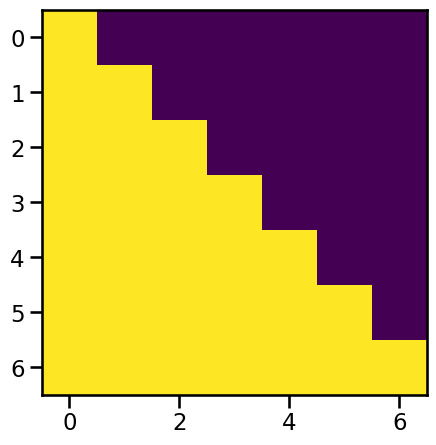

In [11]:
def subsequent_mask( size ):
    # "Mask out subsequent positions."
    '''生成向后遮掩的掩码张量，参数size是掩码张量最后两个维度的大小，它的最后两维形成一个方阵'''
    #在函数中，首先定义掩码张量的形状
    attn_shape = ( 1, size, size )
    # 然后使用np.ones方法向这个形状中添加1元素,形成上三角阵，最后为了节约空间
    # #再使其中的数据类型变为无符号8位整形unit8
    subsequent_mask = np.triu( np.ones( attn_shape ), k=1 ).astype( 'uint8' )

    # 最后将numpy类型转化为torch中的tensor，内部做一个1 - 的操作
    # 在这个其实是做了一个三角阵的反转，subsequent_mask中的每个元素都会被1减
    # 如果是0，subsequent_mask中的该位置由0变成1
    # 如果是1，subsequent_mask中的该位置由1变成9
    return torch.from_numpy( subsequent_mask ) == 0

plt.figure( figsize=( 5, 5 ) )
plt.imshow( subsequent_mask( 7 )[0] )
print( subsequent_mask( 7 ) )

### 输出效果分析

通过观察可视化方阵黄色是True的部分,这里代表被遮掩,紫色代表没有被遮掩的信息,横坐标代表目标词汇的位置,纵坐标代表可查看的位置,
我们看到,在0的位置我们一看望过去都是黄色的,都被遮住了，1的位置一眼望过去还是黄色,说明第一次词还没有产生,从第二个位置看过去,就能看到位置1的词,其他位置看不到以此类推

掩代表遮掩，码就是我们张量中的数值，它的尺寸不定，里面一般只有1和0的元素，.代表位置被遮掩或者不被遮掩，至于是0位置被遮掩还是1位置被遮掩可以自定义，因此它的作用就是让另外一个张量中的一些数值被遮掩,他可以说被替换,它的表现形式是一个张量
在transformer中,掩码张量的主要作用在应用attention(将在下一小节讲解)时，有一些生成的attetion张量中的值计算有可能已知量未来信息而得到的，未来信息被看到是因为训练时会把整个输出结果都一次性进行Embedding，但是理论上解码器的的输出却不是一次就能产生最终结果的，而是一次次通过上一次结果综合得出的，因此，未来的信息可能被提前利用.所以，我们会进行遮掩.
subsequent_mask输出是一个最后两维形成1方阵的下三角阵

<strong>注意力机制(attention)</strong><br>
An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.
We call our particular attention “Scaled Dot-Product Attention”. The input consists of queries and keys of dimension $d_k$, and values of dimension $d_v$. We compute the dot products of the query with all keys, divide each by $\sqrt{d_k}$, and apply a softmax function to obtain the weights on the values.

它需要三个指定的输入Q(query),K(key),V(value),然后通过公式得到注意力的计算结果这个结果代表query在key和value作用下的表示而这个具体的计算规则有很多种,我这里只介绍我们用到的这一种:

<img src="https://pic2.zhimg.com/80/v2-c5dcddf20d8b2d7ce0130fac2071317d_720w.jpg" />

self-attention中，Q和K在点积之后，需要先经过mask再进行softmax，因此，对于要屏蔽的部分，mask之后的输出需要为负无穷，这样softmax之后输出才为0

<font size="4" color="white">Q,K,V的比喻解释:</font><br>
假如我们有一个问题: 结出一段文本，使用一些关键词对它进行描述!
为了方便统一正确答案，这道题可能预先已经给大家写出了一些关键词作为提示,其中这些给出的提示就可以看作是key，
而整个的文本信息就相当于是query，value的含义则更抽象，可以比作是你看到这段文本信息后，脑子里浮现的的答案信息，
这里我们又假设大家最开始都不是很聪明，第一次看到这段文本后脑子里基本上浮现的信息就只有提示这些信息，
因此key与value基本是相同的，但是随着我们对这个问题的深入理解，通过我们的思考脑子里想起来的东西原来越多
并且能够开始对我们query也就是这段文本，提取关键信息进行表示。 这就是注意力作用的过程， 通过这个过程
我们最终脑子里的value发生了变化，
根据提示key生成了query的关键词表示方法，也就是另外一种特征表示方法

刚刚我们说到key和value一般情况下默认是相同，与query是不同的，这种是我们一般的注意力输入形式,但有一种特殊情况，就是我们query与key和value相同，这种情况我们称为自注意力机制，就如同我们的刚刚的例子
使用一般注意力机制，是使用不同于给定文本的关键词表示它。而自注意力机制，
需要用给定文本自身来表达自己，也就是说你需要从给定文本中抽取关键词来表述它，相当于对文本自身的一次


In [12]:
def attention( query, key, value, mask=None, dropout=None ):
    "Compute 'Scaled Dot Product Attention"
    '''注意力机制的实现，输入分别是query，key，value，mask: 掩码张量
    dropout是nn.Dropout层的实例化对象，默认为None
    它的输出有两个,query的注意力表示以及注意力张量'''
    #在函数中，首先取query的最后一维的大小，一般情况下就等同于我们的词嵌入维度，命名为d_k    
    d_k = query.size( -1 )
    #按照注意力公式，将query与key的转置相乘，这里面key是将最后两个维度进行转置，再除以缩放系数
    # 得到注意力得分张量scores
    scores = torch.matmul( query, key.transpose( -2, -1 )) \
             / math.sqrt( d_k )
    
    #接着判断是否使用掩码张量
    if mask is not None:
        # 使用tensor的masked_fi11方法，将掩码张量和scores张量每个位置--比较，如果掩码张量
        # 则对应的scores张量用-1e9这个值来替换，如下演示
        scores = scores.masked_fill( mask == 0.0, -1e9 )

    # 对scores的最后一维进行softmax操作，使用F.softmax方法，第一个参数是softmax对象，第二个
    #这样获得最终的注意力张量
    p_attn = F.softmax( scores, dim=-1 )

    # 之后判断是否使用dropout进行随机置9
    if dropout is not None:
        p_attn = dropout( p_attn )
    
    #最后，根据公式将p_attn与value张量相乘获得最终的query注意力表示，同时返回注意力张量
    return torch.matmul( p_attn, value ), p_attn

MultiHead:<br>

<img  src="http://nlp.seas.harvard.edu/images/the-annotated-transformer_38_0.png" width=25% height=25% />

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

$\mathrm{MultiHead}(Q, K, V) = \mathrm{Concat}(\mathrm{head_1}, ...,
\mathrm{head_h})W^O    \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, WKi∈Rdmodel×dk, WVi∈Rdmodel×dv and WO∈Rhdv×dmodel. In this work we employ h=8 parallel attention layers, or heads. For each of these we use dk=dv=dmodel/h=64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

“多头”机制能让模型考虑到不同位置的Attention，另外“多头”Attention可以在不同的子空间表示不一样的关联关系，使用单个Head的Attention一般达不到这种效果。

+ <font size='5'>多头注意力机制的作用:</font><br>
<font size='3' color="white" >从多头注意力的缩构图中，貌似这个所谓的多个头就是指多组线性变换层，其实并不是,我只有使用了一组线性变化层，即三个变换张量对Q，K，V分别进行线性变换，这些变换不会改变原有张量的尺寸，因此每个变换矩阵都是方阵，得到输出结果后，多头的作用才开始显现，每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后一维的词嵌入向量.这就是所谓的多头，将每个头的获得的输入送到注意力机制中,就形成多头注意力机制<br>
1. 这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果.</font>

In [13]:
class MultiHeadedAttention( nn.Module ):
    def __init__( self, h, d_model, dropout=0.1 ):
        '''在类的初始化时，会传入三个参数，h(head)代表头数，d_model代表词嵌入的维度
        dropout代表进行dropout操作时置0比率，默认是0.1.'''
        super( MultiHeadedAttention, self ).__init__()

        # 在函数中，首先使用了一个测试中常用的assert语句，判断h是否能被d_model整除
        # 这是因为我们之后要给每个头分配等量的词特征.也就是d_model/head个
        assert d_model % h == 0

        # We assume d_v always equals d_k
        #得到每个头获得的分割词向量维度d_k
        self.d_k = d_model // h

        self.h = h

        # 然后获得线性层对象，通过nn的Linear实例化，它的内部变换矩阵是d_model x d_model
        #为什么是四个呢，这是因为在多头注意力中，Q，K，V各需要一个，最后拼接的矩阵还需要一个
        self.linears = clones( nn.Linear( d_model, d_model ), 4 )

        # self.attn为None.它代表最后得到的注意力张量，现在还没有结果所以为None.
        self.attn = None

        # 最后就是一个self.dropout对象，它通过nn中的Dropout实例化而来，置0比率为传进来的参数dropout
        self.dropout = nn.Dropout( p=dropout )

    def forward( self, query, key, value, mask=None ):
        "前向逻辑函数，它的输入参数有四个，前三个就是注意力机制需要的Q，K，V,最后一个是注意力机制中可能需要的mask掩码张量，默认是None."

        #如果存在掩码张量mask
        if mask is not None:
            # 使用unsqueeze拓展维度，代表多头中的第n头
            mask = mask.unsqueeze( 1 )
        
        # 接着，我们获得一个batch_size的变量，他是query尺寸的第1个数字，代表有多少条样本
        nbatches = query.size( 0 )

        # 就进入多头处理环节:
        #首先利用zip将输入QKV与三个线性层组到一起，然后使用for循环，将输入QKV分别传到线性层中
        #做完线性变换后，开始为每个头分割输入，这里使用view方法对线性变换的结果进行维度重塑，多加1个维度h，代表头
        #这样就意味着每个头可以获得一部分词特征组成的句子，其中的-1代表自适应维度
        #计算机会根据这种变换自动计算这里的值.然后对第二维和第三维进行转置操作，
        #为了让代表句子长度维度和词向量维度能够相邻，这样注意力机制才能找到词义与句子位置的关系，
        # 从attention函数中可以看到，利用的是原始输入的倒数第一和第二维.这样我们就得到了每个头输入
        query, key, value = \
            [ l(x).view( nbatches, -1, self.h, self.d_k ).transpose( 1, 2 )
              for l, x in zip( self.linears, ( query, key, value )) ]
        
        #得到每个头的输入后，接下来就是将他们传入到attention中，
        # 这里直接调用我们之前实现的attention函数.同时也将mask和dropout传入其中
        x, self.attn = attention( query, key, value, mask=mask, dropout=self.dropout )

        #通过多头注意力计算后，我们就得到了每个头计算结果组成的4维张量，我们需要将其转换为输入的
        #因此这里开始进行第一步处理环节的逆操作，先对第二和第三维进行转置，然后使用contiquous方法
        #这个方法的作用就是能够让转置后的张量应用view方法，否则将无法直接使用，
        #所以，下一步就是使用view重塑形状，变成和输入形状相同.
        x = x.transpose( 1, 2 ).contiguous() \
            .view( nbatches, -1, self.h * self.d_k )
        
        #最后使用线性层列表中的最后一个线性层对输入进行线性变换得到最终的多头注意力结构的输出.
        return self.linears[-1]( x )

> attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

. 学习了什么是多头注意力机制:<br>
<p>每个头开始从词义层面分割输出的张量，也就是每个头都想获得一组Q，K，V进行注意力机制的计算，但是句子中的每个词的表示只获得一部分，也就是只分割了最后-维的词嵌入向量.这就是所谓的多头.将每个头的获得的输入送到注意力机制中,就形成类多头注意力机制</p>
<p>这种结构设计能让每个注意力机制去优化每个词汇的不同特征部分，从而均衡同一种注意力机制可能产生的偏差，让词义拥有来自更多元的表达，实验表明可以从而提升模型效果</p>

<strong>前馈全连接层:</strong><br>
前馈全连接层就是具有两层线性层的全连接网络,考虑注意力机制可能对复杂过程的拟合程度不够,通过增加两层网络来增强模型的能力

In [14]:
class PositionwiseFeedForward( nn.Module ):
    "Implements FFN equation."
    def __init__( self, d_model, d_ff, dropout=0.1 ):
        """初始化函数有三个输入参数分别是d_model，d_ff,和dropout=0.1，
        第一个是线性层的输入维因为我们希望输入通过前馈全连接层后输入和输出的维度不变，
        第二个参数d_ff就是第一个线性层输出的维度，和第二个线性层输入的维度
        最后一个是dropout置0比率，"""
        super( PositionwiseFeedForward, self ).__init__()
        self.w_1 = nn.Linear( d_model, d_ff )
        self.w_2 = nn.Linear( d_ff, d_model )
        self.dropout = nn.Dropout( dropout )

    def forward( self, x ):
        return self.w_2( self.dropout( F.relu( self.w_1( x ) )) )

<strong>文本嵌入层（Embeddings）</strong><br>
<img src="https://pic2.zhimg.com/80/v2-ca9c861576e2aac1ee7211d4e0bc6281_720w.jpg" /><br>
无论是源文本嵌入还是目标文本嵌入，都是为了将文本中词汇的数字表示转变为向量表示希望在这样的高维空间捕捉词汇间的关系

In [15]:
class Embeddings( nn.Module ):
    def __init__( self, d_model, vocab ):
        super( Embeddings, self ).__init__()
        self.lut = nn.Embedding( vocab, d_model )
        self.d_model = d_model

    def forward( self, x ):
        #在forward函数中将输入x传入到Embedding的实例化对象中,
        # 然后乘以一个根号下d_model进行缩放控制数值大小*它的输出是文本嵌入后的结果
        return self.lut( x ) * math.sqrt( self.d_model ) 

<strong>位置编码器（class PositionalEncoding</strong><br>
因为在Transformer的编码器结构中,并没有针对词汇位置信息的处理，因此需要在Embedding层店加入位置编码器，将词汇位置不同可能会产生不同语义的信息加入到词嵌入张量中,以弥补位置信息的缺失

In [16]:
class PositionalEncoding( nn.Module ):
    "Implement the PE function."
    def __init__( self, d_model, dropout, max_len=5000 ):
        #d_model:词嵌入维度
        #dropout:置0比率
        #max_len:每个句子重大长度
        super( PositionalEncoding, self ).__init__()

        #实例化nn中预定义的Dropout层，并将dropout传入其中，获得self.dropout
        self.dropout = nn.Dropout( p=dropout )

        # Compute the positional encodings once in log space.
        #初始化一个位置矩阵，矩阵大小max_len X d_model
        pe = torch.zeros( max_len, d_model )

        #初始化一个绝对位置矩阵，这里，词汇的绝对位置就是用它的索引表示
        #所以首先用range获得一个连续自然数向量，然后再用unsqueeze拓展向量维度
        position = torch.arange( 0, max_len ).unsqueeze( 1 ).float()

        #绝对位置矩阵初始化之后，接下来就是考虑如何将这些位置信息加入到位置编码矩阵中
        #最简单思路就是先将max_len X 1的绝对位置矩阵， 变换成ax len x d_model形状，然后覆盖原来的初始位置编码矩阵即可
        # 要做这种矩阵变换，就需要一个1xd_model形状的变换矩阵div_term，我们对这个变换矩阵的要求除了形状外
        #还希望它能够将自然数的绝对位置编码缩放成足够小的数字，有助于在之后的梯度下降过程中更快的收敛， 这样我们就可以开始初始
        # 首先使用arange获得一个自然数矩阵， 但是细心的同学们会发现，  我们这里并没有按照预计的一样初始化一个1xd_model的矩阵
        # 而是有了一个跳跃，只初始化了一半即1xd_mode1/2 的矩阵。 为什么是一半呢，其实这里并不是真正意义上的初始化了一半的矩阵
        #我们可以把它看作是初始化了两次，而每次初始化的变换矩阵会做不同的处理，第一次初始化的变换矩阵分布在正弦波上， 第二次初
        # 并把这两个矩阵分别填充在位置编码矩阵的偶数和奇数位置上，组成最终的位置编码矩阵，
        div_term = torch.exp( torch.arange( 0., d_model, 2) * -(math.log(10000.0) / d_model ) )
        pe[ :, 0::2 ] = torch.sin( position * div_term )
        pe[ :, 1::2 ] = torch.cos( position * div_term )
        # 这样我们就得到了位置编码矩阵pe，pe现在还只是一个二维矩阵，要想和embedding的输出(一个
        # 就必须拓展一个维度，所以这里使用unsqueeze拓展维度
        pe = pe.unsqueeze( 0 )
        # 最后把pe位置编码矩阵注册成模型的buffer，什么是buffer呢
        # 我们把它认为是对模型效果有帮助的，但是却不是模型结构中超参数或者参数，不需要随着优化步骤更新的增益对象
        #注册之后我们就可以在模型保存后重加载时和模型结构与参数一同被加载
        self.register_buffer( 'pe', pe )

    def forward( self, x ):
        # forward函数的参数是x，表示文本序列的词嵌入美示
        # 在相加之前我们对pe做一些适配工作， 将这个三维张量的第二维也就是句子最大长度的那一维将切到与输入的x的第二维相同即x.size(1).
        # 因为我们默认max len为5000一般来进实在太大了，很难有一条句子包含5000个词汇，所以要进行与输入张量的适配。
        # 最后使用Variable进行封装，使其与x的样式相同，但是它是不需要进行梯度求解的，因此把requires_grad设置成false.
        # 在原有的信息上叠加了位置信息,保证同一词汇随着所在位置不同它对应位置嵌入向量会发生变化
        # 正弦波和余弦波的值域范围都是1到-1,这又很好的控制了嵌入数值的大小有助于梯度的快速计算
        x = x + Variable( self.pe[ :, :x.size(1) ], requires_grad=False )
        return self.dropout( x )

绘制词汇向量中特征的分布曲线

torch.Size([1, 100, 20])


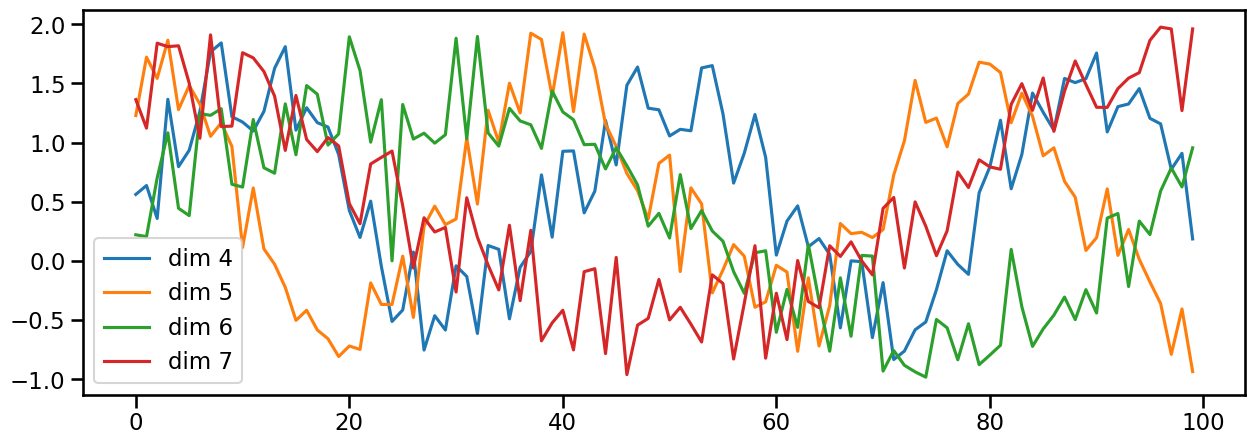

In [17]:
plt.figure( figsize=( 15, 5) )
pe = PositionalEncoding( 20, 0.01 )
#y = pe.forward( Variable( torch.zeros( 1, 100, 20 ) ))
y = pe.forward( Variable( torch.rand( 1, 100, 20 ) ))
print( y.shape )
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

### 输出效果分析:
. 每条颜色的曲线代表某一个词汇中的特征在不同位置的含义 
. 保证同一词汇随着所在位置不同它对应位置嵌入向量会发生变化 
. 正弦波和余弦波的值域范围都是1到1这又很好的控制了嵌入数值的大小,有助于梯度的快速计算


Here we define a function that takes in hyperparameters and produces a full model.

In [18]:
def make_model( src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1 ):
    "Helper: Construct a model from hyperparameters."
    """“该函数用来构建模型，有7个参数，分别是源数据特征(词汇)总数，目标数据特征(词汇)总数,
    编码器和解码器堆叠数，词向量映射维度，前馈全连接网络中变换矩阵的维度，
    多头注意力结构中的多头数，以及置零比率dropout."""

    #首先得到一个深度拷贝命令，接下来很多结构都需要进行深度拷贝
    #来保证他们彼此之间相互独立，不受干扰
    c = copy.deepcopy

    #实例化了多头注意力类，得到对象attn
    attn = MultiHeadedAttention( h, d_model )

    #然后实例化前馈全连接类，得到对象ff
    ff = PositionwiseFeedForward( d_model, d_ff, dropout )

    #实例化位置编码类，得到对象position
    position = PositionalEncoding( d_model, dropout )

    # 根据结构图，最外层是EncoderDecoder，在EncoderDecoder中
    # 分别是编码器层，解码器层，源数据Embedding层和位置编码组成的有序结构,
    #目标数据Embedding层和位置编码组成的有序结构，以及类别生成器层
    #在编码器层中有attention子层以及前馈全连接子层
    #在解码器层中有两个attention子层以及前馈全连接层
    model = EncoderDecoder( 
        Encoder( EncoderLayer( d_model, c(attn), c(ff), dropout ), N ),
        Decoder( DecoderLayer( d_model, c(attn), c(attn), c(ff), dropout ), N ),
        nn.Sequential( Embeddings( d_model, src_vocab ), c(position) ),
        nn.Sequential( Embeddings( d_model, tgt_vocab ), c(position) ),
        Generator( d_model, tgt_vocab )
    )

    # This was important from their code. 
    # Initialize parameters with Glorot / fan_avg.
    #模型结构完成后，接下来就是初始化模型中的参数，比如线性层中的变换矩阵
    #这里一但判断参数的维度大于1，则会将其初始化成一个服从均匀分布的矩阵
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform( p )
    return model


In [19]:
tmp_model = make_model(10, 10, 2)
print( tmp_model )

EncoderDecoder(
  (encoder): Encoder(
    (layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_features=512, bias=True)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=512, out_features=2048, bias=True)
          (w_2): Linear(in_features=2048, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0-1): 2 x SublayerConnection(
            (norm): LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
        )
      )
    )
    (norm): LayerNorm()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0-1): 2 x DecoderLayer(
        (self_attn): MultiHeadedAttention(
          (linears): ModuleList(
            (0-3): 4 x Linear(in_features=512, out_

C:\Users\bluefish\AppData\Local\Temp\ipykernel_25264\2319506515.py:39: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform( p )



## Batches and Masking

In [20]:
class Batch( ):
    "Object for holding a batch of data with mask during training."
    def __init__( self, src, trg=None, pad=0 ):
        self.src = src.to( device )
        self.src_mask = ( src != pad ).unsqueeze( -2 ).to( device )
        if trg is not None:
            """这是因为在seq2seq模型中，解码器需要根据前面预测出的词来生成后面的词，因此在训练过程中我们需要将目标序列向
            右移动一位作为解码器的输入。所以在初始化Batch对象时，将目标语言数据中的最后一列去掉得到self.trg，
            而self.trg_y就是将self.trg向左移动一位得到的结果，即从第二个单词开始的目标序列。
            这样在训练时，解码器的输入就是self.trg_y，而参考答案就是self.trg"""
            self.trg = trg[ :, :-1 ].to( device )
            self.trg_y = trg[ :, 1: ].to( device )

            '''因为在seq2seq模型中，我们的目标是预测序列的下一个单词，即要将整个目标序列向左移动一个位置，
            并在第一个位置添加一个起始符号（start-of-sentence token）作为模型的输入。因此，我们需要对移动
            后的目标序列进行掩码操作，从而控制模型只能看到之前所有单词，而不能看到当前要预测的单词和未来单词。
            在Batch类的初始化函数中，self.trg_y是根据self.trg向左移动一位得到的，而生成目标语言掩码时我们
            需要用到完整的目标语言序列。因此，我们在初始化时先生成了self.trg，然后再用它生成目标语言掩码'''
            self.trg_mask = self.make_std_mask( self.trg, pad  ).to( device )
            self.ntokens = ( self.trg_y != pad ).data.sum().to( device )

    @staticmethod       
    def make_std_mask( tgt, pad ):
        """subsequent_mask()函数的作用是创建一个大小为(size, size)的上三角矩阵，其中对角线及其以下的位置全为1，
        对角线以上的位置全为0。这个掩码矩阵的作用在于，在解码器端预测输出序列时，避免了每个时间步的输出能够访问到
        当前时间步之后的信息，从而确保了模型只能依赖之前的输出而不会利用未来信息进行预测。
           在此处，tgt_mask已经完成了对需要掩码的位置的标记，但是我们还需要将解码器端未来时间步的信息进行掩码，
        使得解码器只能预测当前时间步以及之前的信息。这就是使用subsequent_mask()来实现的，通过与前面得到的掩码
        tgt_mask进行逐元素相乘（element-wise multiplication），即可同时过滤掉需要掩码的位置和未来单词的信息，
        确保模型只能看到当前和之前的信息。
            这里使用Variable()用于将subsequent_mask()生成的tensor转化为PyTorch变量，然后调用.type_as()方法
        将数据类型转换为与tgt_mask相同的数据类型，以便在进行逐元素相乘操作时维度一致。这是因为PyTorch要求进行
        tensor运算时，两个张量需要具有相同的数据类型和设备（CPU或GPU）"""
        tgt_mask = ( tgt != pad ).unsqueeze( -2 )
        tgt_mask = tgt_mask & Variable( 
            subsequent_mask( tgt.size( -1 ) ).type_as( tgt_mask.data )
        )
        return tgt_mask



## Training Loop


In [21]:
def run_epoch( data_iter, model, loss_compute ):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0

    for i, batch in enumerate( data_iter ):        

        out = model.forward( batch.src, batch.trg, \
                             batch.src_mask, batch.trg_mask )
        loss = loss_compute( out, batch.trg_y, batch.ntokens )
        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens

        if i % 50 == 1:
            elapsed = time.time() - start
            print( 'Epoch Step: %4d Loss:%5.4f Tokens per sec  %4.2f' % ( i, loss / batch.ntokens, tokens / elapsed ))
            start = time.time()
            tokens = 0
    
    return total_loss / total_tokens

and Batching

In [22]:
global max_src_in_batch, max_tgt_in_batch

def batch_size_fn( new, count, sofar ):
    "Keep augmenting batch and calculate total number of tokens + padding."
    global max_src_in_batch, max_tgt_in_batch
    if count == 1:
        max_src_in_batch = 0
        max_tgt_in_batch = 0
    max_src_in_batch = max( max_src_in_batch, len( new.src ) )
    max_tgt_in_batch = max( max_tgt_in_batch, len( new.trg ) + 2 )
    src_elemnets = count * max_src_in_batch
    tgt_elements = count * max_tgt_in_batch

    return max( src_elemnets, tgt_elements )



We used the Adam optimizer (cite) with β1=0.9, β2=0.98 and ϵ=10−9.

>> Note: This part is very important. Need to train with this setup of the model.

In [23]:
class NoamOpt():
    "Optim wrapper that implements rate."
    def __init__( self, model_size, factor, warmup, optimizer ):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step( self ):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p[ 'lr' ] = rate
        self._rate = rate
        self.optimizer.step()

    def rate( self, step=None ):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return self.factor * \
                ( self.model_size ** ( -0.5 ) * 
                   min( step ** ( -0.5 ), step * self.warmup ** ( -1.5)))


def get_std_opt( model ):
    return NoamOpt( model.src_embed[0].d_model, 2, 4000,
                  torch.optim.Adam( model.parameters(), lr=0, betas=( 0.9, 0.98 ), eps=1e-9 ))

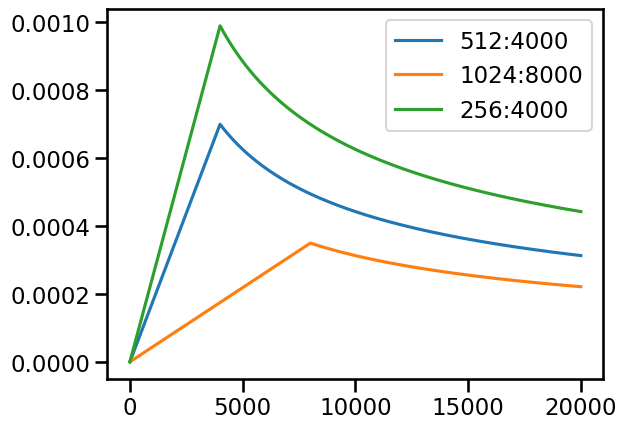

In [24]:
# Three settings of the lrate hyperparameters.
opts = [ NoamOpt( 512, 1, 4000, None ),
         NoamOpt( 1024, 1, 8000, None ),
         NoamOpt( 256, 1, 4000, None )]
plt.plot( np.arange( 1, 20000 ), [ [ opt.rate( i ) for opt in opts ] for i in range( 1, 20000 ) ])
plt.legend( [ '512:4000', '1024:8000', '256:4000'])


## Label Smoothing
令人迷惑，但确实能改善accuracy and BLEU 成绩.<br>
#导入标签平滑工具包，该工具用于标签平滑，标签平滑的作用就是小幅度的改变原有标签值的值域<br>
#因为在理论上即使是人工的标注数据也可能并非完全正确，会受到一些外界因素的影狗而产生一些微小的偏差<br>
#因此使用标签平滑来弥补这种偏差，减少模型对某一条规律的绝对认知，以防止过拟合，<br>

In [25]:
class LabelSmoothing( nn.Module ):
    "Implement label smoothing."
    
    def __init__( self, size, padding_idx, smoothing=0.0 ):
        #第一参数size代表目标数据的词汇总数，也是模型最后一层得到张量的最后一维大小
        #这里是5说明目标词汇总数是5个，第二个参数padding_idx表示要将那些tensor中的数字
        #替换成0，一般padding_idx=0表示不进行替换，第三个参数smoothing，表示标签的平滑程度
        #如原来标签的表示值为1，则平滑后它的值域变为[1-smoothing，1+smoothing]
        super( LabelSmoothing, self ).__init__()
        self.criterion = nn.KLDivLoss( size_average=False )
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward( self, x, target ):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_( self.smoothing / ( self.size - 2 ) )
        true_dist.scatter_( 1, target.data.unsqueeze(1), self.confidence )
        true_dist[ :, self.padding_idx ] = 0
        mask = torch.nonzero( target.data == self.padding_idx )
        if mask.dim() > 0:
            true_dist.index_fill( 0, mask.squeeze(), 0.0 )
        self.true_dist = true_dist
        return self.criterion( x, Variable( true_dist, requires_grad=False ) )

c:\Users\bluefish\.conda\envs\torchEnv\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


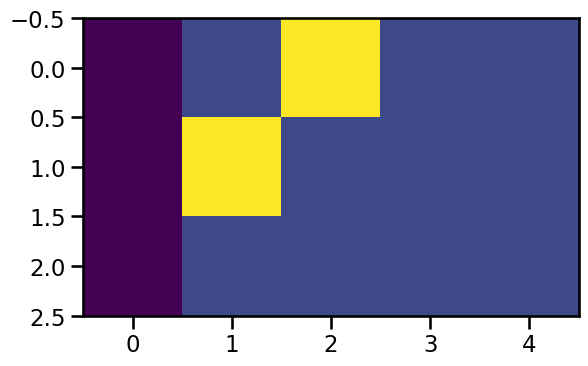

In [26]:
# Example of label smoothing.
crit = LabelSmoothing( 5, 0, 0.4 )
predict = torch.FloatTensor( [[0, 0.2, 0.7, 0.1, 0],
                             [0, 0.2, 0.7, 0.1, 0], 
                             [0, 0.2, 0.7, 0.1, 0]] )
v = crit( Variable( predict.log() ), Variable( torch.LongTensor( [ 2, 1, 0 ] ) ) )
plt.imshow( crit.true_dist )

当model对选择给出非常有信心时， 实际上会开始惩罚model（防止过拟？)

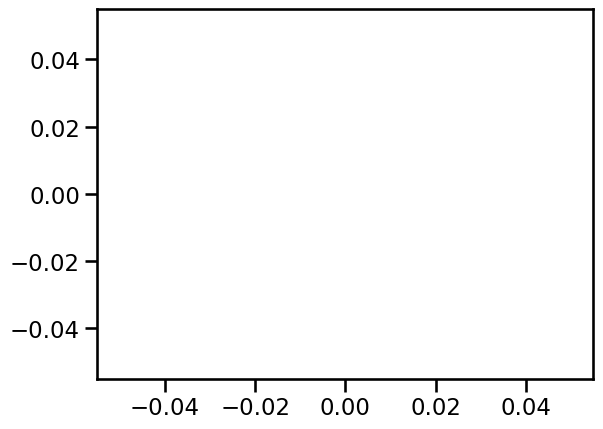

In [27]:
crit = LabelSmoothing( 5, 0, 0.1 )
def loss( x ):
    d = x + 3 * 1
    predict = torch.FloatTensor( [[ 0, x/d, 1/d, 1/d, 1/d ]] )
    return crit( Variable( predict.log() ), Variable( torch.LongTensor( [1] ) ) ).item()

plt.plot( np.arange(1, 100), [loss(x) for x in range(1, 100)] )

In [28]:
# 生成简单测试数据
def data_gen( V, batch, nbatches ):
    "Generate random data for a src-tgt copy task."
    """该函数用于随机生成copy任务的数据，它的三个输入参数是V: 随机生成数字的最大值+1.
    batch: 每次输送给模型更新一次参数的数据量，
    num_batch:一共输送num_batch次完成一轮"""
    for i in range( nbatches ):
        #在循环中使用np的random.randint方法随机生成[1，V)的整数
        #分布在(batch，10)形状的矩阵中，然后再把numpy形式转换称torch中的tensor
        data = torch.from_numpy( np.random.randint( 1, V, size=( batch, 10 ) ) )

        #接着使数据矩阵中的第一列数字都为1，这一列也就成为了起始标志列，
        # 当解码器进行第一次解码的时候，会使用起始标志列作为输入，
        data[ :, 0 ] = 1

        #因为是copy任务，所有source与target是完全相同的，且数据样本作用变量不需要求梯度
        #因此requires_grad设置为False
        src = Variable( data, requires_grad=False ).long()
        tgt = Variable( data, requires_grad=False ).long()

        #使用Batch对source和target进行对应批次的掩码张量生成，最后使用yield返回
        yield Batch( src, tgt, 0 )

#SimpleLossCompute在使用标签平滑后的结果进行损失的计算
#损失的计算方法可以认为是交叉熵损失函数
#同时完成反向传播计算，loss.backward()
# Loss Computation
class SimpleLossCompute():
    "A simple loss compute and train function."
    def __init__( self, generator, criterion, opt=None ):
        self.generator = generator
        self.criterion = criterion
        self.opt = opt

    def __call__( self, x, y, norm ):
        x = self.generator( x )
        loss = self.criterion( x.contiguous().view( -1, x.size(-1) ),
                               y.contiguous().view( -1 ) ) / norm
        loss.backward()
        if self.opt is not None:
            self.opt.step()
            self.opt.optimizer.zero_grad()
        return loss.item() * norm



In [29]:
#贪婪解码的方式是每次预测都选择概率最大的结果作为输出，
#它不一定能获得全局最优性，但却拥有最高的执行效率
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type_as(src.data)
    for i in range(max_len-1):
        out = model.decode(memory, src_mask, 
                           Variable(ys), 
                           Variable(subsequent_mask(ys.size(1))
                                    .type_as(src.data)))
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim = 1)
        next_word = next_word.data[0]
        ys = torch.cat([ys, 
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=1)
    return ys

一个简单例子：<br>
我们可以从一个简单的复制任务开始。给定一个小词汇表中的随机输入符号集，目标是生成这些相同的符号

In [ ]:
V = 11
criterion = LabelSmoothing( size=V, padding_idx=0, smoothing=0.0 )
model = make_model( V, V, N=2 )
model = model.to( device )
model_opt = NoamOpt( model.src_embed[0].d_model, 1, 400,
                     torch.optim.Adam( model.parameters(), lr=1, betas=( 0.9, 0.98 ), eps=1e-9 ) )

for epoch in range( 20 ):
    model.train()
    run_epoch( data_gen( V, 30, 15 ), model, 
                SimpleLossCompute( model.generator, criterion, model_opt ))
    
    print( 'finished epoch:', epoch )
    torch.save( model, 'simple.pth' )
    
    model.eval()
    print( "eval:", run_epoch(data_gen( V, 30, 5 ), model, 
                    SimpleLossCompute( model.generator, criterion, None ) ) ) 

用model进行预测：

In [ ]:
model = make_model( V, V, N=2 ).to( device )
model = torch.load( 'simple.pth' )
model.eval()
src = Variable(torch.LongTensor( [[1,7,7,4,3,6,8,4,9,10]]).to( device ) )
src_mask = Variable(torch.ones(1, 1, 10).to( device ) )
print(greedy_decode(model, src, src_mask, max_len=10, start_symbol=1))

In [ ]:
# For data loading.
from torchtext import data, datasets

if True:
    import spacy
    spacy_de = spacy.load('de_core_news_sm')
    spacy_en = spacy.load('en')

    def tokenize_de(text):
        return [tok.text for tok in spacy_de.tokenizer(text)]

    def tokenize_en(text):
        return [tok.text for tok in spacy_en.tokenizer(text)]

    BOS_WORD = '<s>'
    EOS_WORD = '</s>'
    BLANK_WORD = "<blank>"
    SRC = data.Field(tokenize=tokenize_de, pad_token=BLANK_WORD)
    TGT = data.Field(tokenize=tokenize_en, init_token = BOS_WORD, 
                     eos_token = EOS_WORD, pad_token=BLANK_WORD)

    MAX_LEN = 100
    train, val, test = datasets.IWSLT.splits( exts=( '.de', '.en' ), fields=( SRC, TGT ),
                                               filter_pred=lambda x: len( vars(x)[ 'src']) <= MAX_LEN and
                                                  len( vars(x)[ 'trg' ]) <= MAX_LEN )
    MIN_FREQ = 2
    SRC.build_vocab(train.src, min_freq=MIN_FREQ)
    TGT.build_vocab(train.trg, min_freq=MIN_FREQ)    

数据迭代器

In [ ]:
class MyIterator( data.Iterator ):
    def create_batches( self ):
        if self.train:
            def pool( d, random_shuffler ):
                for p in data.batch( d, self.batch_size * 100 ):
                    p_batch = data.batch( sorted( p, key=self.sort_key ),
                                           self.batch_size, self.batch_size_fn )
                    for b in random_shuffler( list( p_batch ) ):
                        yield b
            self.batches = pool( self.data(), self.random_shuffler )
        else:
            self.batches = []
            for b in data.batch( self.data(), self.batch_size, self.batch_size_fn ):
                self.batches.append( sorted( b, key=self.sort_key ) )

def rebatch( pad_idx, batch ):
    "Fix order in torchtext to match ours"
    src, trg = batch.src.transpose( 0, 1 ), batch.trg.transpose( 0, 1 )
    return Batch( src, trg, pad_idx )

最后为了快速训练，我们使用了多块     GPU。这段代码将实现多 GPU 的词生成，但它并不是针对 Transformer 的具体方法，所以这里并不会具体讨论。多 GPU 训练的基本思想即在训练过程中将词生成分割为语块（chunks），并传入不同的 GPU 实现并行处理，我们可以使用 PyTorch 并行基元实现这一点。

In [ ]:
class MultiGPULossCompute:
    "A multi-gpu loss compute and train function."
    def __init__( self, generator, criterion, devices, opt=None, chunk_size=5 ):
        self.generator = generator
        self.criterion = nn.parallel.replicate( criterion, devices=devices )
        self.opt = opt
        self.devices = devices
        self.chunk_size = chunk_size

    def __call__( self, out, targets, normalize ):
        total = 0.0
        generator = nn.parallel.replicate( self.generator, devices=devices )
        out_scatter = nn.parallel.scatter( out, target_gpus=self.devices )
        out_grad = [ [] for _ in out_scatter ]
        targets = nn.parallel.scatter( targets, target_gpus=self.devices )

        # Divide generating into chunks.
        chunk_size = self.chunk_size
        for i in range( 0, out_scatter[0].size(1), chunk_size ):
            # Predict distributions
            out_column = [ [ Variable( o[ :, i:i+chunk_size ].data, requires_grad=self.opt is not None )]
                           for o in out_scatter ]
            gen = nn.parallel.parallel_apply( generator, out_column )

            # Compute loss
            y = [ ( g.contigous().view( -1, g.size( -1 )), 
                   t[ :, i:i+chunk_size ].contigous().view( -1 ))
                     for g, t in zip( gen, targets ) ]
            loss = nn.parallel.parallel_apply( self.criterion, y )

            # Sum and normalize loss
            l = nn.parallel.gather( loss, target_device=self.devices[0] )
            l = l.sum()[0] / normalize
            total += l.data[0]

            # Backprop loss to output of transformer
            if self.opt is not None:
                l.backward()
                for j, l in enumerate( loss ):
                    out_grad[ j ].append( out_column[ j ][ 0 ].grad.data.clone() ) 

        # Backprop loss to output of transformer
        if self.opt is not None:
            out_grad = [ Variable( torch.cat( og, dim=1 )) for og in out_grad ]
            o1 = out
            o2 = nn.parallel.gather( out_grad,
                                     target_device=self.devices[0] )
            o1.backward( gradient=o2 )
            self.opt.step()
            self.opt.optimizer.zero_grad()

        return total * normalize                                     

我们利用前面定义的函数创建了模型、度量标准、优化器、数据迭代器和并行化：

In [ ]:
devices = [0]
if True:
    pad_idx = TGT.vocab.stoi[ '<blank>' ]
    model = make_model( len(SRC.vocab ), len(TGT.vocab ), N=6 )
    model.cuda()
    criterion = LabelSmoothing( size=len( TGT.vocab ), padding_idx=pad_idx, smoothing=0.1 )
    criterion.cuda()
    BATCH_SIZE = 12000

    train_iter = MyIterator( train, batch_size=BATCH_SIZE, device=0, repeat=False, 
                             sort_key=lambda x: ( len( x.src ), len( x.trg ) ), 
                             batch_size_fn=batch_size_fn, train=True )
    
    valid_iter = MyIterator( val, batch_size=BATCH_SIZE, device=0, repeat=False,
                              sort_key=lambda x: ( len( x.src ), len( x.trg ) ),
                              batch_size_fn=batch_size_fn, train=False )
    
    model_par = nn.DataParallel( model, device_ids=devices )



In [ ]:
if True:
    model_opt = NoamOpt( model.src_embed[0].d_model, 1, 2000,
                         torch.optim.Adam( model.parameters(), lr=0, betas=( 0.9, 0.98 ), eps=1e-9 ) )

    for epoch in range( 10 ):
        model_par.train()
        run_epoch( ( rebatch( pad_idx, b ) for b in train_iter ),
                    model_par,
                    MultiGPULossCompute( model.generator, criterion,
                                         devices=devices, opt=model_opt ))
        model_par.eval()
        loss = run_epoch( ( rebatch( pad_idx, b ) for b in valid_iter ),
                           model_par, 
                           MultiGPULossCompute( model.generator, criterion,
                                                devices=devices, opt=None ) )
        print( loss )
else:
    model = torch.load( 'iwslt.pt' )

In [ ]:
model, SRC, TGT = torch.load("E:/ML_data/attention/en-de-model.pt")

In [ ]:
model.eval()
sent = "▁The ▁log ▁file ▁can ▁be ▁sent ▁secret ly ▁with ▁email ▁or ▁FTP ▁to ▁a ▁specified ▁receiver".split()
src = torch.LongTensor([[SRC.stoi[w] for w in sent]])
src = Variable( src )
src_mask = ( src != SRC.stoi[ '<blank>' ] ).unsqueeze( -2 )
out = greedy_decode( model, src, src_mask, 
                     max_len=60, start_symbol=TGT.stoi[ '<s>' ] )

print( 'Translation:', end='\t' )
trans = '<s>'
for i in range( 1, out.size( 1 ) ):
    sym =TGT.itos[ out[ 0, i ] ]
    if sym == '</s>':
        break
    trans += sym + ' '
print( trans )


## Attention Visualization

In [ ]:
tgt_sent = trans.split()
def draw( data, x, y, ax ):
    seaborn.heatmap( data, 
                     xticklabels=x, square=True, yticklabels=y, vmin=0.0, vmax=1.0,
                     cbar=False, ax=ax )

for layer in range( 1, 6, 2 ):
    fig, axs = plt.subplots( 1, 4, figsize=( 20, 10 ) )
    print( 'Encoder layer: ', layer+1 )
    for h in range( 4 ):
        draw( model.encoder.layers[ layer ].self_attn.attn[ 0, h ].data,
              sent, sent if h==0 else [], ax=axs[h] )
    plt.show()

for layer in range( 1, 6, 2 ):
    fig, axs = plt.subplots( 1,4, figsize=( 20, 10 ) )
    print( 'Decoder Self layer :', layer+1 )
    for h in range( 4 ):
        draw( model.decoder.layers[ layer ].self_attn.attn[ 0, h ].data[ :len( tgt_sent ), :len( tgt_sent )],
              tgt_sent, tgt_sent if h==0 else [], ax=axs[h] )
    plt.show()

    print( 'Decoder Src Layer : ', layer+1 )
    fig, axs = plt.subplots( 1, 4, figsize=( 20, 10 ) )
    for h in range( 4 ):
        draw( model.decoder.layers[ layer ].self_attn.attn[ 0, h ].data[ :len( tgt_sent ), :len( sent ) ],
              sent, tgt_sent if h ==0 else [], ax=axs[h] )
    plt.show()


####  开始一个NMT项目

In [31]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import spacy

spacy_zh = spacy.load('zh_core_web_sm')
spacy_en = spacy.load('en_core_web_sm')

def tokenize_zh(text):
    return [tok.text for tok in spacy_zh.tokenizer(text)]

def tokenize_en(text):
    return [tok.text for tok in spacy_en.tokenizer(text)]

def read_file_iter(file_path):
    with open(file_path, 'r') as f:
        for line in f:
            yield line.strip()

def data_generator(src_data, trg_data, batch_size=32):
    num_samples =min(  len(src_data), len( trg_data ) )
    
    for i in range( 0, num_samples, batch_size ):
        src = src_data[ i : min( i + batch_size, num_samples ) ]  
        trg = trg_data[ i : min( i + batch_size, num_samples ) ]
        src.to( device )
        trg.to( device )
        yield Batch( src, trg )     

zh_file = "D:/dataset/news-commentary-v12.zh-en.small.zh"
en_file ="D:/dataset/news-commentary-v12.zh-en.small.en"

#建词汇表
vocab_zh = build_vocab_from_iterator( map( tokenize_zh, read_file_iter( zh_file) ), specials=[ '<unk>', '<pad>', '<bos>', '<eos>'] )
vocab_zh.set_default_index( vocab_zh[ '<unk>'] )

vocab_en = build_vocab_from_iterator( map( tokenize_en, read_file_iter( en_file) ), specials=[ '<unk>', '<pad>', '<bos>', '<eos>'] )
vocab_en.set_default_index( vocab_en[ '<unk>'] )

#文本分词并且向量化
voc_list_zh = [ torch.tensor( vocab_zh( [ '<bos>' ] ) + vocab_zh( tokenize_zh( text )) + vocab_zh( ['<eos>']), dtype=torch.long )  for text in read_file_iter( zh_file )  ]
voc_list_en = [ torch.tensor( vocab_zh( [ '<bos>' ] ) + vocab_en( tokenize_en( text )) + vocab_zh( ['<eos>']), dtype=torch.long )  for text in read_file_iter( en_file )  ]

#扩展到统一维度
voc_zh = torch.nn.utils.rnn.pad_sequence( voc_list_zh, batch_first=True)
voc_en = torch.nn.utils.rnn.pad_sequence( voc_list_en, batch_first=True)   

In [ ]:
#voc_zh = voc_zh[:22700 ]
#voc_en = voc_en[:22700 ]

train_len, val_len, test_len = int( len( voc_zh) *0.8 ), int( len( voc_zh) *0.1 ), int( len( voc_zh) *0.1 )
train_voc_zh = voc_zh[ :train_len ]
train_voc_en = voc_en[ :train_len ]
val_voc_zh = voc_zh[ train_len+1 : train_len + val_len ]
val_voc_en = voc_en[ train_len+1 : train_len + val_len ]
test_voc_zh = voc_zh[ -test_len: ]
test_voc_en = voc_en[ -test_len: ]

print( train_voc_zh.shape, train_voc_en.shape )
print( val_voc_zh.shape, val_voc_en.shape )
print( test_voc_zh.shape, test_voc_en.shape )

建立模型，开始train model

In [ ]:
vocab_len_zh = len( vocab_zh )
vocab_len_en = len( vocab_en )
model_file = 'news-commentary_en_to_zh.pth'

#英文->中文
criterion = LabelSmoothing( size=vocab_len_zh, padding_idx=0, smoothing=0.01 )
model = make_model( vocab_len_en, vocab_len_zh, N=2 )

if ( os.path.exists( model_file ) ):
    model = torch.load( model_file )

model = model.to( device )
model_opt = NoamOpt( model.src_embed[0].d_model, 1, 400,
                     torch.optim.Adam( model.parameters(), lr=1, betas=( 0.9, 0.98 ), eps=1e-9 ) )

for epoch in range( 50 ):
    model.train()
    run_epoch( data_generator( train_voc_en, train_voc_zh, batch_size=4 ), model, 
                SimpleLossCompute( model.generator, criterion, model_opt ))
    
    print( 'finished epoch:', epoch )
    torch.save( model, 'news-commentary_en_to_zh.pth' )
    
    model.eval()
    print( "eval:", run_epoch( data_generator( val_voc_en, val_voc_zh, batch_size=4 ), model, 
                    SimpleLossCompute( model.generator, criterion, None ) ) ) 
    

In [36]:
model_file = 'news-commentary_en_to_zh.pth'
model = torch.load( model_file )
model.eval()
#sent_str = 'Globalization may also facilitate legal tax avoidance.'
#sent_str = 'The younger the girl, the higher the price.'
sent_str = 'China is also forging new institutions..'

src = Variable( torch.tensor( [ vocab_zh( [ '<bos>' ] ) + vocab_en( tokenize_en( sent_str )) + vocab_zh( ['<eos>']) ], dtype=torch.long )  ).to( device )
src_mask = Variable(torch.ones(1, 1, src.size(1) ) ).to( device )
print( src, src_mask  )
result = greedy_decode(model, src, src_mask, max_len=20, start_symbol=2)
print( result.cpu().tolist() )
print( vocab_zh.lookup_tokens( result.cpu().tolist()[0] ) )

tensor([[   2,   69,   13,   94, 4446,   64,  348,    0,    3]],
       device='cuda:0') tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1.]]], device='cuda:0')
[[2, 29, 4, 177, 490, 15, 68, 1858, 45, 1533, 1866, 91, 66, 5, 52, 125, 46, 108, 6, 3]]
['<bos>', '我们', '的', '农业', '劳动力', '将', '从', '手中', '到', '今后', '数十', '年', '来', '，', '并', '增加', '其', '重要', '。', '<eos>']


In [37]:
print( src.size() )
print( result.cpu().tolist()[0] )
a = torch.ones(3)
b = a.numpy()
print( a, b)


torch.Size([1, 9])
[2, 29, 4, 177, 490, 15, 68, 1858, 45, 1533, 1866, 91, 66, 5, 52, 125, 46, 108, 6, 3]
tensor([1., 1., 1.]) [1. 1. 1.]


In [ ]:
vocab_len_zh = len( vocab_zh )
vocab_len_en = len( vocab_en )

for epoch in range( 20 ):
    print( 'epoch:', epoch )
    for data in data_generator( train_voc_en, train_voc_zh, batch_size=512 ):
        print( data.src.shape )


In [ ]:
texts = ['美国会恢复得更好，但并不是唯一能恢复的国家', '当富人不再那么富了，穷人就会更穷。']

vocab_zh = build_vocab_from_iterator( map( tokenize_zh, texts ), specials=[ '<unk>', '<pad>', '<bos>', '<eos>'] )
#t = [ torch.tensor(  vocab_zh( ['<bos>'] ) + vocab_zh( tokenize_zh( text ) + vocab_zh( ['<eos>'] ) ), dtype=torch.long )  for text in texts  ]
t = [ torch.tensor( vocab_zh( [ '<bos>' ] ) + vocab_zh( tokenize_zh( text ) ) + vocab_zh( ['<eos>']), dtype=torch.long )  for text in texts  ]
print( vocab_zh( [ '<unk>', '<pad>', '<bos>', '<eos>' ]))
print( vocab_zh.lookup_token(5)  )
print( t )


'''
r = map( len, t )
print( max( list( r ) ))

def padding_voc( voc, max_pad_num=15  ):
    t_padding = torch.zeros( max_pad_num )
    t_padding[ :len(voc) ] = voc
    return t_padding

r = list( map( lambda x: padding_voc( x, max_pad_num=20 ), t ) )
print(   r  )

vectors = [[1, 2], [3, 4, 5], [6, 7, 8, 9], [10]]
print( [torch.tensor(vector) for vector in vectors] )
print( torch.nn.utils.rnn.pad_sequence( voc_list_zh, batch_first=True) )
'''